## **1.Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Cargar el archivo Excel
df = pd.read_excel("DatosAgroNet_limpio.xlsx")
df_total = df.copy()

train_size = int(len(df_total) * 0.8)
test_size = len(df_total) - train_size
df = df.iloc[:train_size]


# Mostrar las primeras filas
print(df.head())

       Fecha   COP/kg
0 2024-01-01  14271.7
1 2024-01-08  14223.3
2 2024-01-15  14086.3
3 2024-01-22  14329.2
4 2024-01-29  14530.8


### Transformación Box-Cox

In [17]:
from scipy.stats import boxcox

# Supón que df es tu DataFrame con la columna 'COP/kg' positiva
serie = df['COP/kg'].values

# Aplicar Box-Cox, que devuelve la serie transformada y el lambda óptimo
serie_bc, fitted_lambda = boxcox(serie)

# Guardar la serie transformada en el DataFrame
df['COP/kg_boxcox'] = serie_bc

print("Lambda óptimo para Box-Cox:", fitted_lambda)

Lambda óptimo para Box-Cox: 2.9434690557997727


## **3. Definir los parámetros**
`(p,d,q)` → parte no estacional

p: rezagos autorregresivos (cuántos valores pasados usa).  
d: diferencias necesarias para estacionarizar la serie.  
q: rezagos de errores pasados (parte MA).

`(P,D,Q,s)` → parte estacional

P: rezagos autorregresivos estacionales.  
D: diferencias estacionales necesarias (ej. 1 si la serie tiene ciclos anuales).  
Q: rezagos de errores pasados estacionales.  
s: longitud del ciclo → en datos semanales es 52 (1 año ≈ 52 semanas).

In [4]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

mejor_mse = float("inf")
mejores_parametros = None
mejor_modelo = None

p = d = q = range(0, 3)  # prueba valores de 0 a 2
P = D = Q = range(0, 2)  # valores típicos más bajos para estacionalidad
#s = 52  # periodicidad estacional semanal anual

for s in [4, 12, 26, 52]: 
    for i in p:
        for j in d:
            for k in q:
                for I in P:
                    for J in D:
                        for K in Q:
                            try:
                                modelo = SARIMAX(df['COP/kg'],
                                                order=(i,j,k),
                                                seasonal_order=(I,J,K,s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                resultado = modelo.fit(disp=False)

                                # Pronóstico
                                forecast = resultado.get_forecast(steps=test_size)
                                pred_mean = forecast.predicted_mean
                                mse = mean_squared_error(df_total['COP/kg'].iloc[-test_size:], pred_mean)

                                if mse < mejor_mse:
                                    mejor_mse = mse
                                    mejores_parametros = ((i,j,k), (I,J,K,s))
                                    mejor_modelo = resultado
                            except:
                                continue

if mejores_parametros is not None:
    print(f'Mejor modelo SARIMA: orden no estacional {mejores_parametros[0]}, orden estacional {mejores_parametros[1]}, MSE: {mejor_mse}')
else:
    print("No se encontró ningún modelo SARIMA válido.")


Mejor modelo SARIMA: orden no estacional (2, 1, 2), orden estacional (0, 0, 1, 52), MSE: 4794109.039603894


## **4. Aplicar el modelo a los datos**

In [25]:
# Ajustar el modelo SARIMA (p,d,q) ( P,D,Q,s)
modelo = SARIMAX(df['COP/kg'], 
                 order=mejores_parametros[0], 
                 seasonal_order=mejores_parametros[1],
                 enforce_stationarity=False, 
                 enforce_invertibility=False)

resultado = modelo.fit()

print(resultado.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               COP/kg   No. Observations:                   64
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 52)   Log Likelihood                 -65.978
Date:                              Sun, 12 Oct 2025   AIC                            143.956
Time:                                      23:07:49   BIC                            144.432
Sample:                                           0   HQIC                           140.741
                                               - 64                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6312      0.707      2.306      0.021       0.245       3.017
ar.L2         -0.76

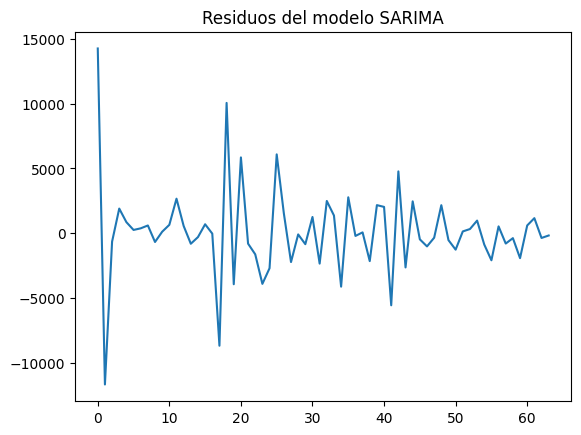

In [26]:
residuos = resultado.resid
import matplotlib.pyplot as plt
plt.plot(residuos)
plt.title("Residuos del modelo SARIMA")
plt.show()

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(lb_test)

from scipy.stats import shapiro
print(shapiro(residuos))

      lb_stat  lb_pvalue
10  20.637752   0.023766
ShapiroResult(statistic=np.float64(0.8638763204246074), pvalue=np.float64(4.452957783548329e-06))


1. Prueba de autocorrelación (Ljung-Box, ACF/PACF):  
Se usa para detectar dependencia temporal residual no modelada.  
Si p-valor > 0.05: no se rechaza independencia, residuos adecuados.  
Si p-valor ≤ 0.05: hay autocorrelación, revisar parámetros.  

2. Pruebas de normalidad (Shapiro-Wilk, Jarque-Bera):  
Verifica si residuos siguen distribución normal (supuesto común en modelos clásicos).  
Si p-valor > 0.05: no se rechaza normalidad, validando supuestos.  
Si p-valor ≤ 0.05: residuos no normales, considerar transformaciones sobre COP/kg o métodos robustos (modelos no lineales como LSTM o XGBoost).  

In [8]:
# Hacer predicción para el próximo semestre (26 semanas)
prediccion = resultado.get_forecast(steps=test_size)

# Extraer predicción y intervalos de confianza
media_prediccion = prediccion.predicted_mean
intervalos_confianza = prediccion.conf_int()

In [9]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], media_prediccion)
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], media_prediccion))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 1784.5428
RMSE: 2189.5454


## **5. Graficar los resultados del forecast**

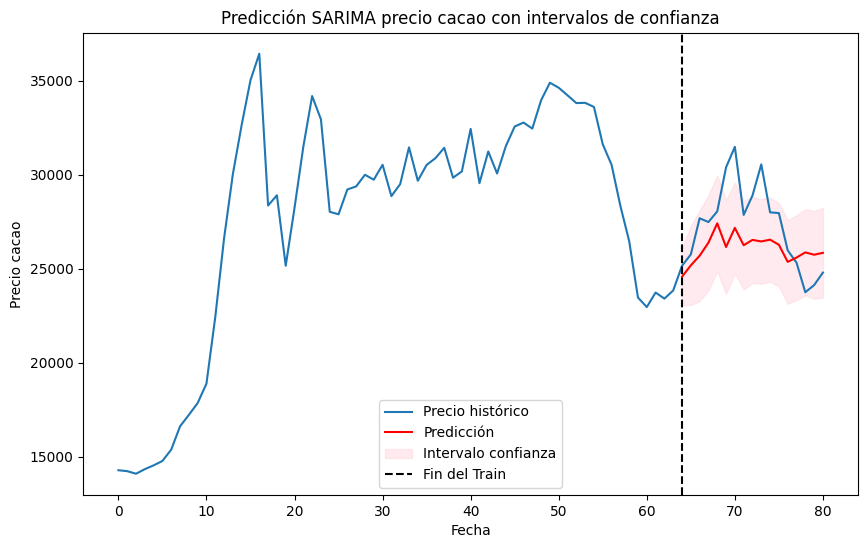

In [10]:
# Graficar datos históricos y predicción con intervalos de confianza
plt.figure(figsize=(10,6))
plt.plot(df_total.index, df_total['COP/kg'], label='Precio histórico')
plt.plot(media_prediccion.index, media_prediccion, color='red', label='Predicción')
plt.fill_between(intervalos_confianza.index, 
                 intervalos_confianza.iloc[:, 0], 
                 intervalos_confianza.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo confianza')
plt.axvline(df_total.index[train_size], color='k', linestyle='--', label='Fin del Train')

plt.xlabel('Fecha')
plt.ylabel('Precio cacao')
plt.title('Predicción SARIMA precio cacao con intervalos de confianza')
plt.legend()
plt.show()

El modelo logró capturar el alza de precios y refleja un posible escenario de continuidad de la tendencia alsista. Los intervalos de confianza amplios sugieren que el cacao es **altamente volátil**, y que el pronóstico sirve más como rango de posibles escenarios que como cifra exacta.